In [24]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings("ignore")
from typing import Dict

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torch import nn

import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping

import pytorch_forecasting as ptf
from pytorch_forecasting import TimeSeriesDataSet, DeepAR, NHiTS, TemporalFusionTransformer, RecurrentNetwork, DecoderMLP
from pytorch_forecasting.data import NaNLabelEncoder, TorchNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import RMSE, NormalDistributionLoss, MultivariateNormalDistributionLoss, MQF2DistributionLoss, QuantileLoss
from pytorch_forecasting.models import BaseModel

from gp_mjo.utils.create_df import create_dataframe

In [2]:
npzfile = np.load('../data/obs/mjo_new_data.npz', allow_pickle=True)
print(npzfile.files)
print(npzfile['RMM1'].shape)

data_names = npzfile.files + ['id']
n_files = len(data_names)

entire_npzfile = {}
for i, data_name in enumerate(data_names):
    if i < n_files-1:
        entire_npzfile[data_name] = npzfile[data_name]
    if i == n_files-1:
        entire_npzfile[data_name] = np.arange(len(npzfile['RMM1']))

# Create the DataFrame using the function
df = create_dataframe(entire_npzfile)

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
(16624,)


In [3]:
print(df[0:16624])

print(df[16624:])

          value group  time_idx        date  phase  amplitude
0      0.142507  RMM1         0  1979-01-01    6.0   1.060090
1     -0.204200  RMM1         1  1979-01-02    7.0   1.388700
2     -0.158610  RMM1         2  1979-01-03    7.0   1.547580
3     -0.182450  RMM1         3  1979-01-04    7.0   1.471080
4     -0.320050  RMM1         4  1979-01-05    7.0   1.181000
...         ...   ...       ...         ...    ...        ...
16619  0.386045  RMM1     16619  2024-07-02    3.0   1.455303
16620  0.367469  RMM1     16620  2024-07-03    3.0   1.589958
16621  0.209546  RMM1     16621  2024-07-04    3.0   1.466880
16622  0.202304  RMM1     16622  2024-07-05    3.0   1.178915
16623  0.412928  RMM1     16623  2024-07-06    3.0   1.128464

[16624 rows x 6 columns]
          value group  time_idx        date  phase  amplitude
16624  1.050470  RMM2         0  1979-01-01    6.0   1.060090
16625  1.373610  RMM2         1  1979-01-02    7.0   1.388700
16626  1.539430  RMM2         2  1979-01-03 

In [4]:
# create dataset and dataloaders
width = 40
lead_time = 60
n_pred = 528
n = 10000
v = 2000
m = 5000
start_train = 0
n_offset = 0

batch_size = 128
seed = 99
static_categoricals = []#['group'] #[] for 'NHiTS' 'FCNModel', ['group'] #as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
target_normalizer = None # None, TorchNormalizer(), EncoderNormalizer()

training_cutoff = start_train + n + lead_time + width - 2 #df["time_idx"].max() - lead_time

start_forecast_val = training_cutoff + 1 + width # start_train + n + lead_time + n_offset 
validation_cutoff = start_forecast_val + v + lead_time - 2

start_forecast_test = start_train + width + n + n_offset + width \
                + v + n_offset + 10 + width
test_forecast_ids = np.arange( start_forecast_test, min( start_forecast_test + m, len(df) // 2 ) )
test_cutoff = start_forecast_test + n_pred + lead_time - 2


# create the dataset from the pandas dataframe
training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    target="value",
    time_idx="time_idx",
    group_ids=["group"],
    categorical_encoders={"group": NaNLabelEncoder().fit(df.group)},
    static_categoricals = static_categoricals,
    min_encoder_length=width,
    max_encoder_length=width,
    min_prediction_length=lead_time,
    max_prediction_length=lead_time,
    time_varying_unknown_reals=["value"],
    target_normalizer=target_normalizer,
)


validation = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= validation_cutoff],
    target="value",
    time_idx="time_idx",
    group_ids=["group"],
    categorical_encoders={"group": NaNLabelEncoder().fit(df.group)},
    static_categoricals = static_categoricals,
    min_encoder_length=width,
    max_encoder_length=width,
    min_prediction_length=lead_time,
    max_prediction_length=lead_time,
    min_prediction_idx = start_forecast_val,
    time_varying_unknown_reals=["value"],
    target_normalizer=target_normalizer,
)

test = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= test_cutoff],
    target="value",
    time_idx="time_idx",
    group_ids=["group"],
    categorical_encoders={"group": NaNLabelEncoder().fit(df.group)},
    static_categoricals = static_categoricals,
    min_encoder_length=width,
    max_encoder_length=width,
    min_prediction_length=lead_time,
    max_prediction_length=lead_time,
    min_prediction_idx = start_forecast_test,
    time_varying_unknown_reals=["value"],
    target_normalizer=target_normalizer,
)

# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized",
    shuffle=True, generator=torch.Generator().manual_seed(seed),
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized",
    shuffle=True, generator=torch.Generator().manual_seed(seed),
)
test_dataloader = test.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized",
    shuffle=True, generator=torch.Generator().manual_seed(seed),
)

In [5]:
print( train_dataloader.dataset )
print( val_dataloader.dataset )
print( test_dataloader.dataset )

TimeSeriesDataSet[length=20000](
	time_idx='time_idx',
	target='value',
	group_ids=['group'],
	weight=None,
	max_encoder_length=40,
	min_encoder_length=40,
	min_prediction_idx=0,
	min_prediction_length=60,
	max_prediction_length=60,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=[],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['value'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=TorchNormalizer(method='identity', center=True, transformation=None, method_kwargs={}),
	categorical_encoders={'group': NaNLabelEncoder(add_nan=False, warn=True), '__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={},
	randomize_length=None,
	predict_mode=False
)
TimeSeriesDataSet[length=4000](
	time_idx='time_idx',
	target='value',
	group_ids=['group'],
	weigh

# DeepAR

In [8]:
device = "cpu" #["cpu", "mps", "cuda", "tpu", "hpu"]
pl.seed_everything(seed)

hidden_size = 64
lr = 3e-2
rnn_layers = 1
max_epochs = 3

Seed set to 99


In [9]:
trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=lr,
    hidden_size=hidden_size,
    rnn_layers=rnn_layers,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr: 100%|██████████| 100/100 [00:02<00:00, 43.49it/s]
Learning rate set to 0.056234132519034905
Restoring states from the checkpoint path at /Users/hchen/gp-mjo/SINDy_RealData/experiments/.lr_find_c1b8bf1d-3cb1-4046-b314-ad8e97d2f943.ckpt
Restored all states from the checkpoint at /Users/hchen/gp-mjo/SINDy_RealData/experiments/.lr_find_c1b8bf1d-3cb1-4046-b314-ad8e97d2f943.ckpt


suggested learning rate: 0.056234132519034905


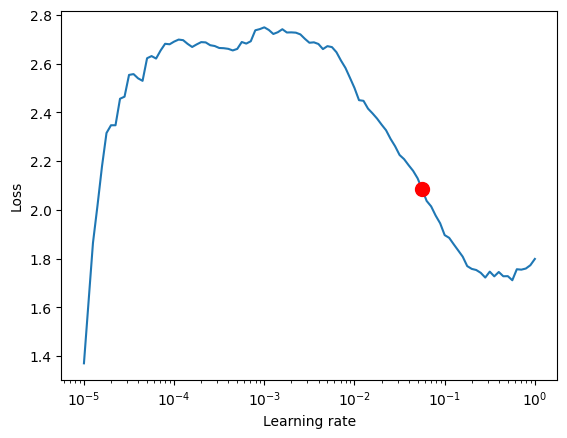

In [10]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [11]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator=device,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    hidden_size=hidden_size,
    rnn_layers=rnn_layers,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params | Mode 
--------------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList                         | 0      | train
2 | embeddings             | MultiEmbedding                     | 2      | train
3 | rnn                    | LSTM                               | 17.4 K | train
4 | distribution_projector | Linear                             | 2.1 K  | train
--------------------------------------------------------------------------------------
19.5 K    Trainable params
0         Non-trainable params
19.5 K    Total params
0.078     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 50/50 [04:18<00:00,  0.19it/s, v_num=35, train_loss_step=-0.182, val_loss=-0.268, train_loss_epoch=-0.217]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 50/50 [04:19<00:00,  0.19it/s, v_num=35, train_loss_step=-0.182, val_loss=-0.268, train_loss_epoch=-0.217]


In [12]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [13]:
# best_model = net
predictions = best_model.predict(test_dataloader, mode="prediction", 
                                trainer_kwargs=dict(accelerator=device), 
                                return_index=True, return_x=True, return_y=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
raw_predictions = net.predict(
    test_dataloader, mode="raw", 
    return_index=True, return_x=True, return_y=True, 
    n_samples=100, 
    trainer_kwargs=dict(accelerator=device)
)

GPU available: True (mps), used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [15]:
predictions.x['decoder_target'].shape

torch.Size([1056, 60])

In [16]:
predictions.index.group == 'RMM1'

0        True
1       False
2        True
3       False
4        True
        ...  
1051    False
1052     True
1053    False
1054     True
1055    False
Name: group, Length: 1056, dtype: bool

In [17]:
raw_predictions.x['decoder_cont'].shape

torch.Size([1056, 60, 1])

In [18]:
raw_predictions.output[0].mean(dim=-1).shape

torch.Size([1056, 60])

In [19]:
entire_npzfile['RMM1'][start_forecast_test:start_forecast_test+8]

array([ 1.4858876 ,  1.4127605 ,  0.87013769,  0.36032364, -0.2242689 ,
       -0.52937448, -0.56909633, -0.33208254])

In [20]:
print(raw_predictions.x['decoder_target'][:4, :8])
print(raw_predictions.output[0].mean(dim=-1)[:4, :8])

tensor([[ 1.4859,  1.4128,  0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321],
        [ 2.1455,  2.9191,  3.2661,  3.2807,  3.2044,  3.2006,  2.7466,  2.1816],
        [ 1.4128,  0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321, -0.0778],
        [ 2.9191,  3.2661,  3.2807,  3.2044,  3.2006,  2.7466,  2.1816,  1.7408]])
tensor([[ 1.2471,  1.0196,  0.8272,  0.6206,  0.4258,  0.2958,  0.1818,  0.0432],
        [ 1.6097,  1.2548,  0.8414,  0.4869,  0.2285, -0.0423, -0.2731, -0.4182],
        [ 1.3870,  1.1560,  0.9537,  0.7165,  0.4707,  0.4230,  0.4124,  0.3936],
        [ 2.1169,  1.6341,  1.1657,  0.7380,  0.3770,  0.0779, -0.2109, -0.3979]])


In [21]:
lead_time_id = 0
RMSE()(raw_predictions.x['decoder_cont'].squeeze()[:,lead_time_id][None,:], 
       raw_predictions.output[0].mean(dim=-1)[:,lead_time_id][None,:])

tensor(0.7566)

In [23]:
lead_time_id = 0
RMSE()(predictions.x['decoder_cont'].squeeze()[:,lead_time_id][:,None], 
       predictions.output[:,lead_time_id][:,None])

tensor(0.7560)

In [24]:
predictions.output.shape

torch.Size([1056, 60])

In [190]:
predictions.output[predictions.index.group == 'RMM1']

tensor([[ 1.4239,  1.3409,  1.2561,  ..., -1.7521, -1.6877, -1.6196],
        [ 1.4632,  1.4088,  1.3061,  ..., -1.8059, -1.7711, -1.7460],
        [ 1.3893,  1.3717,  1.2565,  ..., -2.0053, -1.9316, -1.9248],
        ...,
        [-1.5626, -1.8241, -2.0137,  ..., -1.9796, -1.9755, -1.9901],
        [-1.3055, -1.4449, -1.5756,  ..., -1.8870, -1.8625, -1.8465],
        [-1.4148, -1.5460, -1.6694,  ..., -1.8822, -1.8896, -1.8480]])

In [198]:
raw_predictions.output[0][raw_predictions.index.group == 'RMM1'].shape

torch.Size([528, 60, 100])

In [193]:
predictions.output[(0,2,4),:8]

tensor([[1.4239, 1.3409, 1.2561, 1.1243, 0.9648, 0.8177, 0.6118, 0.3598],
        [1.4632, 1.4088, 1.3061, 1.1830, 1.0075, 0.8025, 0.6483, 0.4598],
        [1.3893, 1.3717, 1.2565, 1.1139, 0.9733, 0.8386, 0.6476, 0.4889]])

In [206]:
predictions.x['decoder_target'][predictions.index.group == 'RMM1'][:3,:8]

tensor([[ 1.4859,  1.4128,  0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321],
        [ 1.4128,  0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321, -0.0778],
        [ 0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321, -0.0778,  0.1272]])

In [207]:
entire_npzfile['RMM1'][start_forecast_test:start_forecast_test+11]

array([ 1.4858876 ,  1.4127605 ,  0.87013769,  0.36032364, -0.2242689 ,
       -0.52937448, -0.56909633, -0.33208254, -0.07775909,  0.12718512,
        0.12812702])

# NHiTS

In [6]:
device = "cpu" #["cpu", "mps", "cuda", "tpu", "hpu"]
pl.seed_everything(seed)

hidden_size = 64
lr = 3e-2
rnn_layers = 1
max_epochs = 5

weight_decay = 1e-2

Seed set to 99


In [7]:
pl.seed_everything(seed)
trainer = pl.Trainer(accelerator=device, gradient_clip_val=0.1)
net = NHiTS.from_dataset(
    training,
    learning_rate=lr,
    weight_decay=weight_decay,
    loss=MQF2DistributionLoss(prediction_length=lead_time),
    backcast_loss_ratio=0.0,
    hidden_size=hidden_size,
    optimizer="AdamW",
)

Seed set to 99
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    net, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5, max_lr=1e-1
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

NameError: free variable 'encoder_features' referenced before assignment in enclosing scope

In [223]:
gradient_clip_val = 0.1
limit_train_batches = 30 # 50 for DeepVAR

In [224]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator=device,
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    callbacks=[early_stop_callback],
    limit_train_batches=limit_train_batches,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    weight_decay=weight_decay,
    backcast_loss_ratio=0.0,
    hidden_size=hidden_size,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=lead_time),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | loss            | MQF2DistributionLoss | 11.7 K | train
1 | logging_metrics | ModuleList           | 0      | train
2 | embeddings      | MultiEmbedding       | 0      | train
3 | model           | NHiTS                | 39.9 K | train
-----------------------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 30/30 [00:02<00:00, 10.18it/s, v_num=31, train_loss_step=0.123, val_loss=0.0943, train_loss_epoch=0.0896] 

: 

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NHiTS.load_from_checkpoint(best_model_path)

In [ ]:
# best_model = net
predictions = best_model.predict(test_dataloader, mode="prediction", 
                        trainer_kwargs=dict(accelerator=device), 
                        return_index=True, return_x=True, return_y=True)

raw_predictions = net.predict(
    test_dataloader, mode="raw", 
    return_index=True, return_x=True, return_y=True, 
    n_samples=100, 
    trainer_kwargs=dict(accelerator=device)
)

In [ ]:
lead_time_id = 0
RMSE()(predictions.x['decoder_target'][:,lead_time_id][:,None], 
       predictions.output[:,lead_time_id][:,None])

In [ ]:
lead_time_id = 0
RMSE()(raw_predictions.x['decoder_target'][:,lead_time_id][None,:], 
       raw_predictions.output[0].mean(dim=-1)[:,lead_time_id][None,:])

# RNN

In [177]:
device = "cpu" #["cpu", "mps", "cuda", "tpu", "hpu"]
pl.seed_everything(seed)

hidden_size = 64
lr = 3e-2
rnn_layers = 1
max_epochs = 5

weight_decay = 1e-2
cell_type = 'GRU' # ['LSTM', 'GRU']

Seed set to 99


# FCN

In [6]:
class FCNModule(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, n_outputs: int):
        super().__init__()

        # input layer
        module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        # hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        # output layer
        self.n_outputs = n_outputs
        module_list.append(
            nn.Linear(hidden_size, output_size * n_outputs)
        )  # <<<<<<<< modified: replaced output_size with output_size * n_outputs

        self.sequential = nn.Sequential(*module_list)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x of shape: batch_size x n_timesteps_in
        # output of shape batch_size x n_timesteps_out
        return self.sequential(x).reshape(x.size(0), -1, self.n_outputs)  # <<<<<<<< modified: added reshape


In [8]:
class FCN(BaseModel):  # we inherit the `from_dataset` method
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int, **kwargs):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)
        self.network = FCNModule(
            input_size=self.hparams.input_size,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
            n_outputs=2,  # <<<<<<<< we predict two outputs for mean and scale of the normal distribution
        )
        self.loss = NormalDistributionLoss()

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs = {
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"
        assert (
            len(dataset.time_varying_known_categoricals) == 0
            and len(dataset.time_varying_known_reals) == 0
            and len(dataset.time_varying_unknown_categoricals) == 0
            and len(dataset.static_categoricals) == 0
            and len(dataset.static_reals) == 0
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "Only covariate should be the target in 'time_varying_unknown_reals'"

        return super().from_dataset(dataset, **new_kwargs)

    def forward(self, x: Dict[str, torch.Tensor], n_samples: int = None) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        network_input = x["encoder_cont"].squeeze(-1)
        prediction = self.network(network_input)  # shape batch_size x n_decoder_steps x 2
        # we need to scale the parameters to real space
        prediction = self.transform_output(
            prediction=prediction,
            target_scale=x["target_scale"],
        )
        if n_samples is not None:
            # sample from distribution
            prediction = self.loss.sample(prediction, n_samples)
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)


model = FCN.from_dataset(training, hidden_size=10, n_hidden_layers=2)
model.hparams

"hidden_size":                 10
"input_size":                  40
"learning_rate":               0.001
"log_gradient_flow":           False
"log_interval":                -1
"log_val_interval":            -1
"logging_metrics":             ModuleList()
"monotone_constaints":         {}
"n_hidden_layers":             2
"optimizer":                   Ranger
"optimizer_params":            None
"output_size":                 60
"output_transformer":          TorchNormalizer(method='identity', center=True, transformation=None, method_kwargs={})
"reduce_on_plateau_min_lr":    1e-05
"reduce_on_plateau_patience":  1000
"reduce_on_plateau_reduction": 2.0
"weight_decay":                0.0

In [17]:
device = "cpu" #["cpu", "mps", "cuda", "tpu", "hpu"]
pl.seed_everything(seed)

hidden_size = 64
lr = 3e-2
rnn_layers = 1
max_epochs = 3
n_hidden_layers=1

Seed set to 99


In [18]:
trainer = pl.Trainer(accelerator=device, gradient_clip_val=1e-1)
net = FCN.from_dataset(
    training,
    learning_rate=lr,
    hidden_size=hidden_size,
    n_hidden_layers=n_hidden_layers,
    loss=NormalDistributionLoss(),
    optimizer="Adam",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:  92%|█████████▏| 92/100 [00:00<00:00, 443.53it/s]
LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.1445439770745927
Restoring states from the checkpoint path at /Users/hchen/gp-mjo/SINDy_RealData/experiments/.lr_find_9f99eb30-b2a2-4065-93d8-2b15e91ad322.ckpt
Restored all states from the checkpoint at /Users/hchen/gp-mjo/SINDy_RealData/experiments/.lr_find_9f99eb30-b2a2-4065-93d8-2b15e91ad322.ckpt


suggested learning rate: 0.1445439770745927


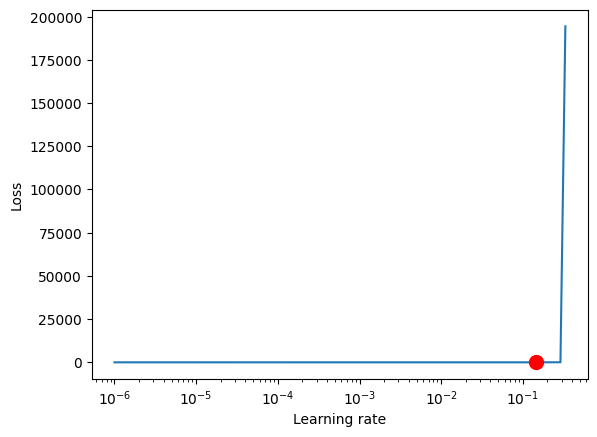

In [19]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-6,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [22]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator=device,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = FCN.from_dataset(
    training,
    # learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=1,
    hidden_size=hidden_size,
    n_hidden_layers=n_hidden_layers,
    optimizer="Adam",
    loss=NormalDistributionLoss(),
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                   | Params | Mode 
-------------------------------------------------------------------
0 | loss            | NormalDistributionLoss | 0      | train
1 | logging_metrics | ModuleList             | 0      | train
2 | network         | FCNModule              | 14.6 K | train
-------------------------------------------------------------------
14.6 K    Trainable params
0         Non-trainable params
14.6 K    Total params
0.058     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 50/50 [03:21<00:00,  0.25it/s, v_num=98, train_loss_step=1.770, val_loss=1.430, train_loss_epoch=1.460]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 50/50 [03:21<00:00,  0.25it/s, v_num=98, train_loss_step=1.770, val_loss=1.430, train_loss_epoch=1.460]


In [23]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = FCN.load_from_checkpoint(best_model_path)

In [25]:
# best_model = net
predictions = best_model.predict(test_dataloader, mode="prediction", 
                                trainer_kwargs=dict(accelerator=device), 
                                return_index=True, return_x=True, return_y=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
raw_predictions = net.predict(
    test_dataloader, mode="raw", 
    return_index=True, return_x=True, return_y=True, 
    n_samples=100, 
    trainer_kwargs=dict(accelerator=device)
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
raw_predictions.output[0].shape

torch.Size([1056, 60, 100])

In [34]:
print( entire_npzfile['RMM1'][start_forecast_test:start_forecast_test+8] )
print( entire_npzfile['RMM2'][start_forecast_test:start_forecast_test+8] )
print(raw_predictions.x['decoder_target'][:4, :8])
print(raw_predictions.output[0].mean(dim=-1)[:4, :8])

[ 1.4858876   1.4127605   0.87013769  0.36032364 -0.2242689  -0.52937448
 -0.56909633 -0.33208254]
[2.1454837 2.9190524 3.2660966 3.2806582 3.2044053 3.2006223 2.7466192
 2.1816049]
tensor([[ 1.4859,  1.4128,  0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321],
        [ 2.1455,  2.9191,  3.2661,  3.2807,  3.2044,  3.2006,  2.7466,  2.1816],
        [ 1.4128,  0.8701,  0.3603, -0.2243, -0.5294, -0.5691, -0.3321, -0.0778],
        [ 2.9191,  3.2661,  3.2807,  3.2044,  3.2006,  2.7466,  2.1816,  1.7408]])
tensor([[ 0.6157,  0.5562,  0.2558,  0.6585,  0.5660,  0.0780,  0.3375,  0.0535],
        [ 0.6736,  0.6732,  0.5957,  1.0690,  0.6387,  0.4163,  0.6208,  0.4220],
        [ 0.5565,  0.5274,  0.2114,  0.4212,  0.4629, -0.0373,  0.1066, -0.1597],
        [ 0.5997,  0.6609,  0.6632,  1.1282,  0.7291,  0.3404,  0.4386,  0.2999]])


In [43]:
lead_time_id = 0
RMSE()(raw_predictions.x['decoder_target'].squeeze()[:,lead_time_id][None,:], 
       raw_predictions.output[0].mean(dim=-1)[:,lead_time_id][None,:])

tensor(0.6956)

In [44]:
lead_time_id = 0
RMSE()(predictions.x['decoder_target'][:,lead_time_id][:,None], 
       predictions.output[:,lead_time_id][:,None])

tensor(0.6963)

# TFT

In [170]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [171]:
# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [172]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 528    | train
6  | decoder_variable_selecti

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]
